#### Problem Statement: Churn Prediction with multilabel :
##### Create a multilable classification model that use historical data and pertinent features to identify consumers who are most likely to churn.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import kaggle
import zipfile


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
import xgboost
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score

import warnings
warnings.filterwarnings('ignore')

## 1.Data Preparation: 

##### 1.1 Data collection and labeling
##### Source of Data:
###### https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics

In [2]:
#use the kaggle API to download the dataset
!kaggle datasets download -d shilongzhuang/telecom-customer-churn-by-maven-analytics

telecom-customer-churn-by-maven-analytics.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# save the downloaded dataset and read only the necessary csv file 
zipfile_name= 'telecom-customer-churn-by-maven-analytics.zip'
with zipfile.ZipFile(zipfile_name, 'r') as file:
    file.extract('telecom_customer_churn.csv')

In [4]:
# read and display general information about the dataset
df = pd.read_csv('telecom_customer_churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

In [5]:
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [6]:
# shape of the dataset
df.shape

(7043, 38)

In [7]:
# display the columns
df.columns

Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')

##### Insight:'Customer Status' is the target feature. 

### 2. Data Cleaning

In [8]:
# normalize the header names
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [9]:
#check for null value
df.isnull().sum()

customer_id                             0
gender                                  0
age                                     0
married                                 0
number_of_dependents                    0
city                                    0
zip_code                                0
latitude                                0
longitude                               0
number_of_referrals                     0
tenure_in_months                        0
offer                                   0
phone_service                           0
avg_monthly_long_distance_charges     682
multiple_lines                        682
internet_service                        0
internet_type                        1526
avg_monthly_gb_download              1526
online_security                      1526
online_backup                        1526
device_protection_plan               1526
premium_tech_support                 1526
streaming_tv                         1526
streaming_movies                  

##### Insight: 14 features contain null values

In [10]:
# Check the value_counts of the features that contain null values
columns_with_null = [col for col in df.columns if df[col].isnull().any()]

for col in columns_with_null:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

avg_monthly_long_distance_charges
[42.39 10.69 33.65 27.82  7.38]
3583

multiple_lines
['No' 'Yes' nan]
2

internet_type
['Cable' 'Fiber Optic' 'DSL' nan]
3

avg_monthly_gb_download
[16. 10. 30.  4. 11.]
49

online_security
['No' 'Yes' nan]
2

online_backup
['Yes' 'No' nan]
2

device_protection_plan
['No' 'Yes' nan]
2

premium_tech_support
['Yes' 'No' nan]
2

streaming_tv
['Yes' 'No' nan]
2

streaming_movies
['No' 'Yes' nan]
2

streaming_music
['No' 'Yes' nan]
2

unlimited_data
['Yes' 'No' nan]
2

churn_category
[nan 'Competitor' 'Dissatisfaction' 'Other' 'Price']
5

churn_reason
[nan 'Competitor had better devices' 'Product dissatisfaction'
 'Network reliability' 'Limited range of services']
20



In [11]:
# There are three main ways of filling out missing values
# drop the null values, fill with 0 or fill with average
# for this we fill out the null values with average of each 
num_types = ['int64', 'float64']
numeric = list(df.select_dtypes(include=num_types))
for col in numeric:
    df[col].fillna(value=df[col].mean(), inplace=True)

In [12]:
df[numeric].isnull().sum()

age                                  0
number_of_dependents                 0
zip_code                             0
latitude                             0
longitude                            0
number_of_referrals                  0
tenure_in_months                     0
avg_monthly_long_distance_charges    0
avg_monthly_gb_download              0
monthly_charge                       0
total_charges                        0
total_refunds                        0
total_extra_data_charges             0
total_long_distance_charges          0
total_revenue                        0
dtype: int64

In [13]:
# for categrical values we either drop the null value 
# or fill with most occuring word in the feature
categorical = list(df.select_dtypes(include='O'))
for col in categorical:
    most_occurring_word = df[col].mode()[0]
    df[col] = df[col].fillna(most_occurring_word)

In [14]:
df[categorical].isnull().sum()

customer_id               0
gender                    0
married                   0
city                      0
offer                     0
phone_service             0
multiple_lines            0
internet_service          0
internet_type             0
online_security           0
online_backup             0
device_protection_plan    0
premium_tech_support      0
streaming_tv              0
streaming_movies          0
streaming_music           0
unlimited_data            0
contract                  0
paperless_billing         0
payment_method            0
customer_status           0
churn_category            0
churn_reason              0
dtype: int64

In [15]:
df.isnull().sum()

customer_id                          0
gender                               0
age                                  0
married                              0
number_of_dependents                 0
city                                 0
zip_code                             0
latitude                             0
longitude                            0
number_of_referrals                  0
tenure_in_months                     0
offer                                0
phone_service                        0
avg_monthly_long_distance_charges    0
multiple_lines                       0
internet_service                     0
internet_type                        0
avg_monthly_gb_download              0
online_security                      0
online_backup                        0
device_protection_plan               0
premium_tech_support                 0
streaming_tv                         0
streaming_movies                     0
streaming_music                      0
unlimited_data           

In [16]:
df[numeric].describe().T

,count,mean,std,min,25%,50%,75%,max
age,7043.0,46.509726,16.750352,19.000000,32.000000,46.000000,60.000000,80.000000
number_of_dependents,7043.0,0.468692,0.962802,0.000000,0.000000,0.000000,0.000000,9.000000
zip_code,7043.0,93486.070567,1856.767505,90001.000000,92101.000000,93518.000000,95329.000000,96150.000000
latitude,7043.0,36.197455,2.468929,32.555828,33.990646,36.205465,38.161321,41.962127
longitude,7043.0,-119.756684,2.154425,-124.301372,-121.788090,-119.595293,-117.969795,-114.192901
number_of_referrals,7043.0,1.951867,3.001199,0.000000,0.000000,0.000000,3.000000,11.000000
tenure_in_months,7043.0,32.386767,24.542061,1.000000,9.000000,29.000000,55.000000,72.000000
avg_monthly_long_distance_charges,7043.0,25.420517,13.495231,1.010000,14.455000,25.420517,36.395000,49.990000
avg_monthly_gb_download,7043.0,26.189958,17.334960,2.000000,15.000000,26.000000,27.000000,85.000000
monthly_charge,7043.0,63.596131,31.204743,-10.000000,30.400000,70.050000,89.750000,118.750000


### 3. Data Exploration and EDA

##### Univariate Analysis

In [17]:
#let's explore the target feature 
df.customer_status.value_counts()

Stayed     4720
Churned    1869
Joined      454
Name: customer_status, dtype: int64

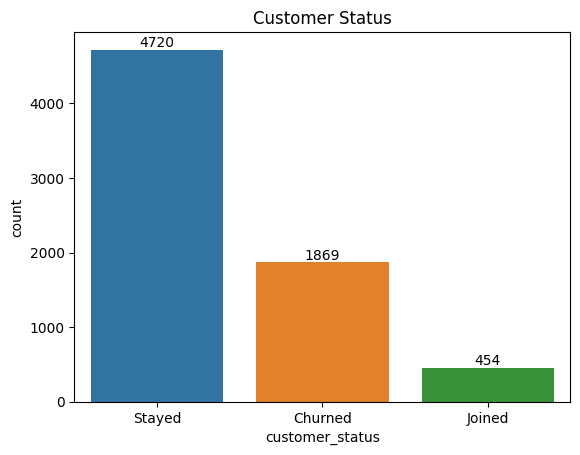

In [18]:
#plot the customer_status feature
plt.title("Customer Status")
ax = sns.countplot(data=df, x='customer_status')
for container in ax.containers:
    ax.bar_label(container)

###### Insight: The number of Churned Customers out numbers the joined customers

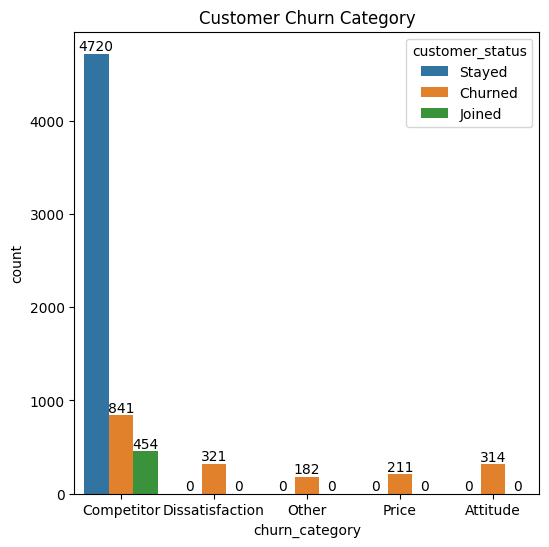

In [19]:
plt.figure(figsize=(6,6))
plt.title("Customer Churn Category")
ax = sns.countplot(data=df, x=df.churn_category, hue=df.customer_status)
for container in ax.containers:
    ax.bar_label(container)

###### Insight: Competitor is the biggest reason for churning

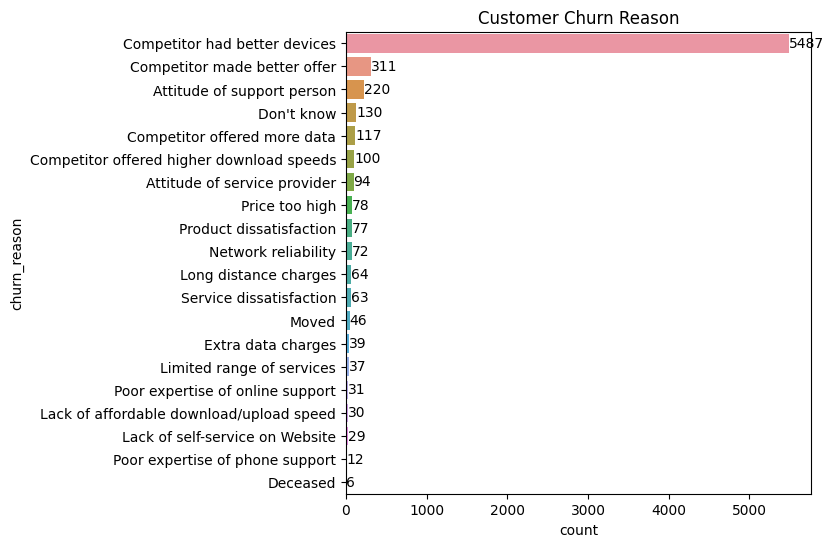

In [20]:
plt.figure(figsize=(6,6))
plt.title("Customer Churn Reason")
ax = sns.countplot(data = df, y='churn_reason',
              order = df['churn_reason'].value_counts().index)
for container in ax.containers:
    ax.bar_label(container)

###### Insight: Most of the reason for churning is "Competitor had better devices"

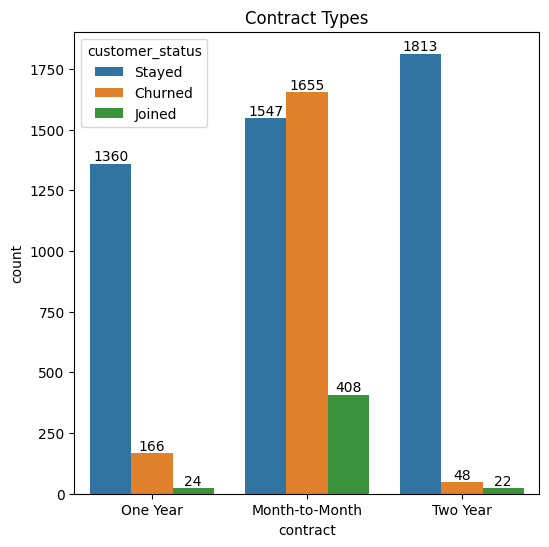

In [21]:
plt.figure(figsize=(6,6))
plt.title("Contract Types")
ax= sns.countplot(data=df, x=df.contract, hue=df.customer_status)
for container in ax.containers:
    ax.bar_label(container)

##### Insight:
###### Customer on month-to-month contract churn the most

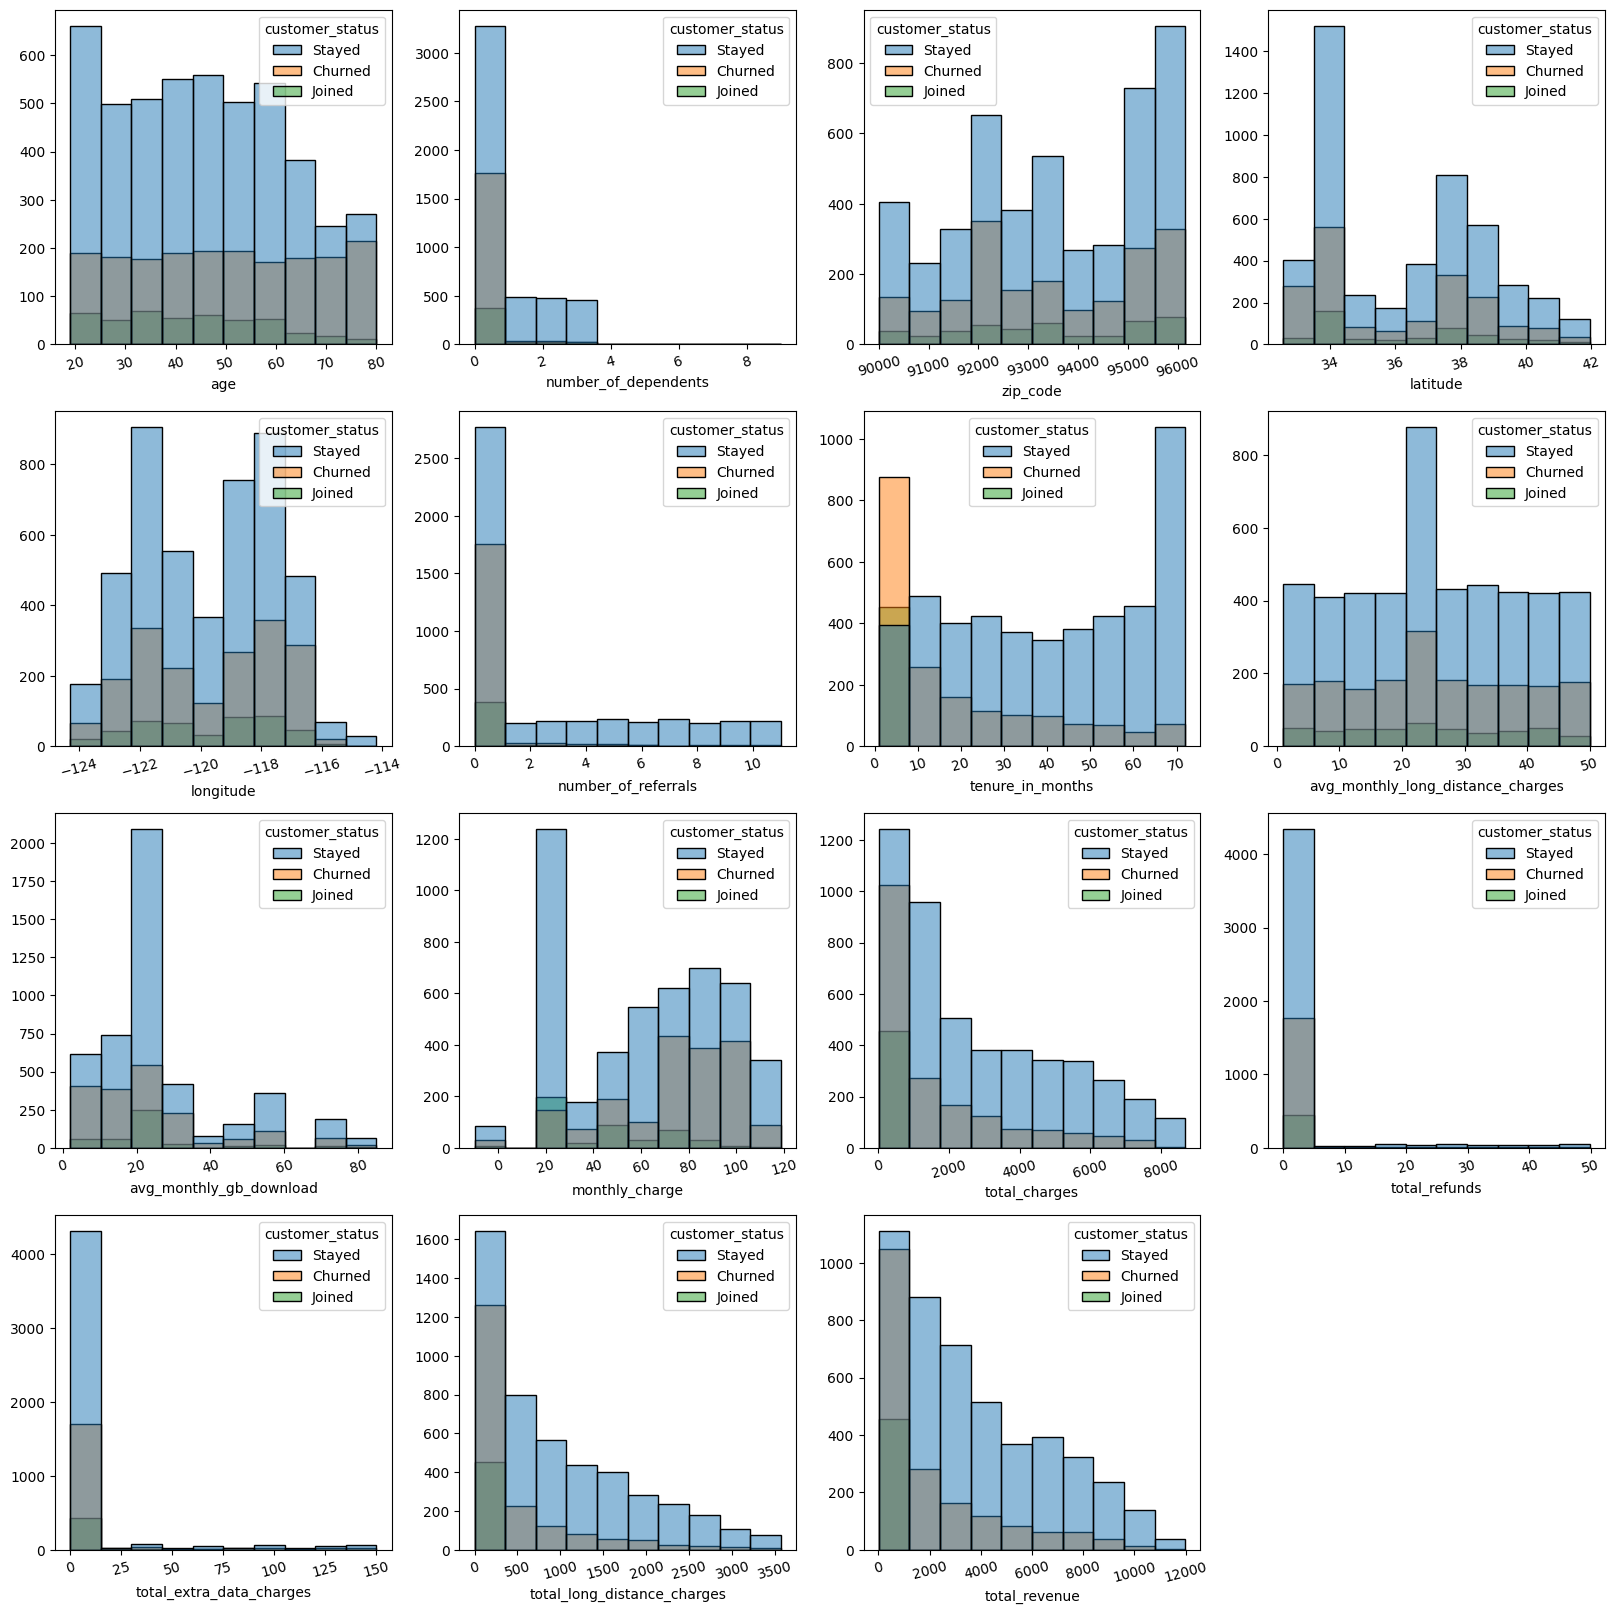

In [22]:
#plot the numeric features 
plt.figure(figsize = (20,20))

j = 1
for col in df[numeric].columns:
    plt.subplot(4,4,j)
    ax = sns.histplot(x = df[col],hue = df['customer_status'], bins=10)
    ax.set( ylabel = None)
    plt.xticks(rotation = 15)
    j += 1

##### Insight:
###### From 'tenure_in_months' we see that new customers Churn the most

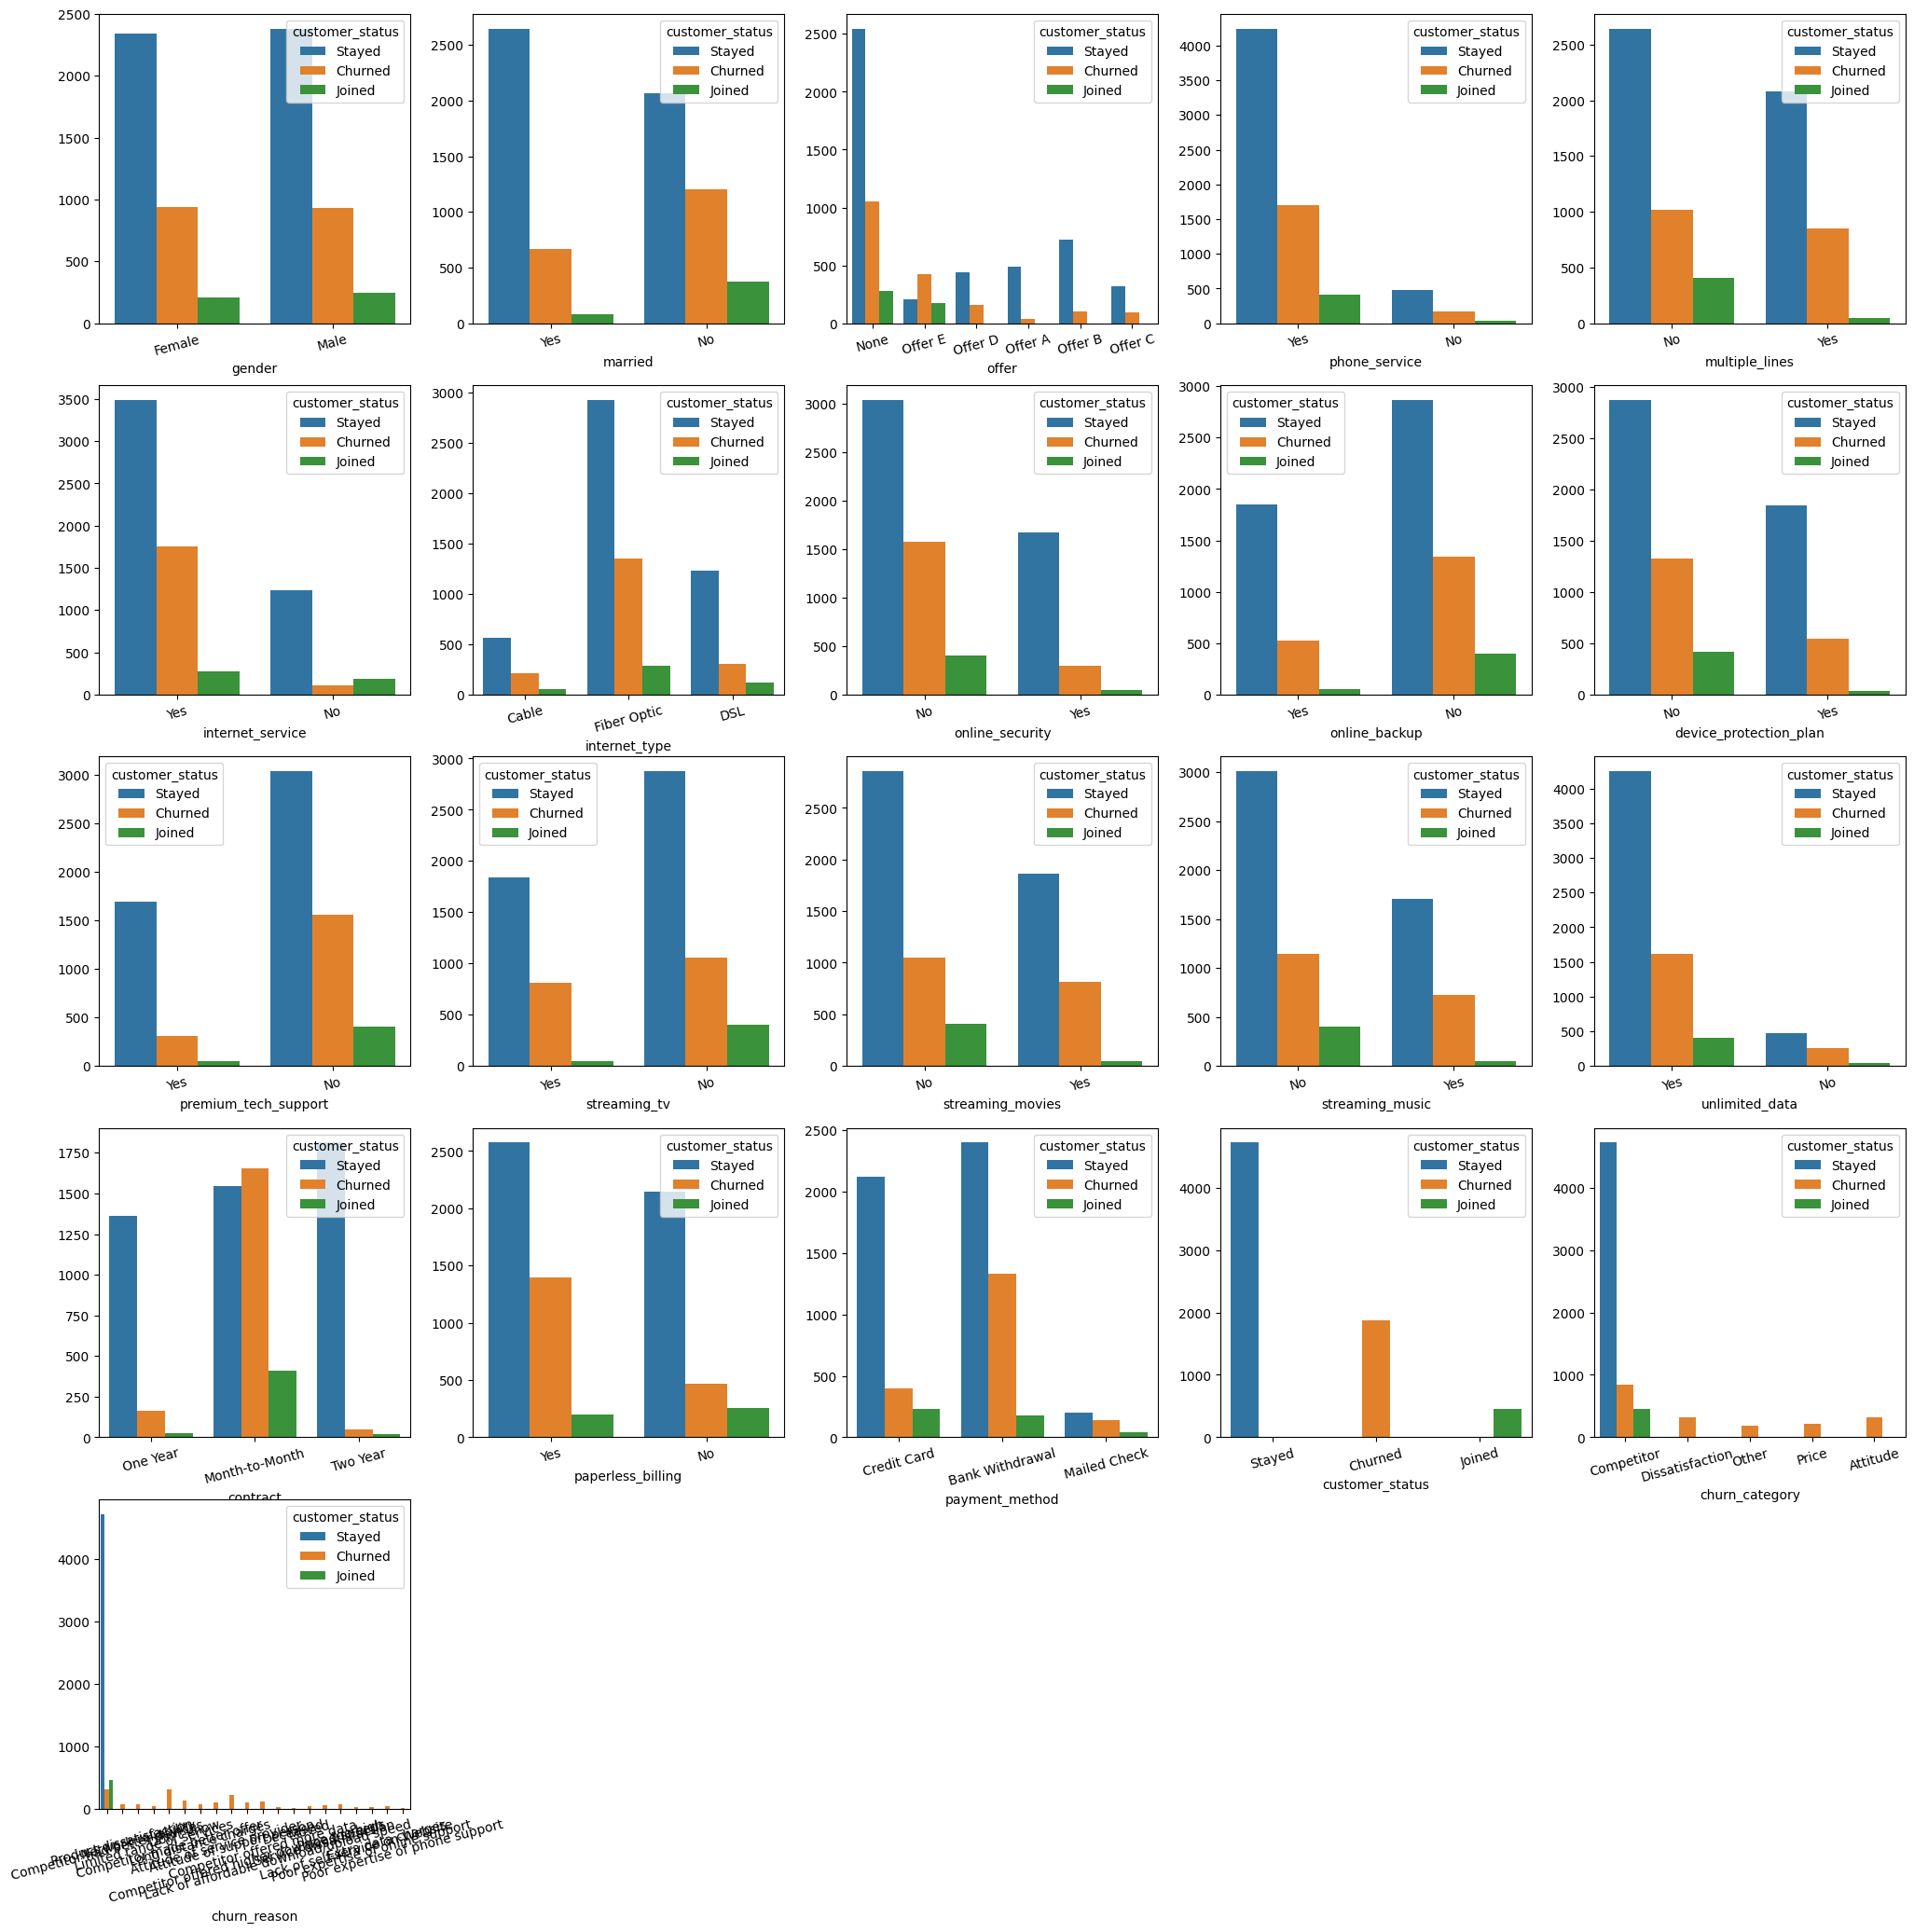

In [23]:
cats = list(df.select_dtypes(include=['O']))
cats.remove('customer_id')
cats.remove('city')
plt.figure(figsize = (25,25))

j=1
for col in cats:
    plt.subplot(5,5,j)
    ax = sns.countplot(x = df[col],hue = df['customer_status'])
    ax.set( ylabel = None)
    plt.xticks(rotation = 15)
    j += 1

##### Insight:
###### Both genders have the same Churning rate
###### Customers who are single churn the most
###### Customers who received None offer churn the most
###### Customers who are on month-to-month contract churn the most


### Bivariate Analysis

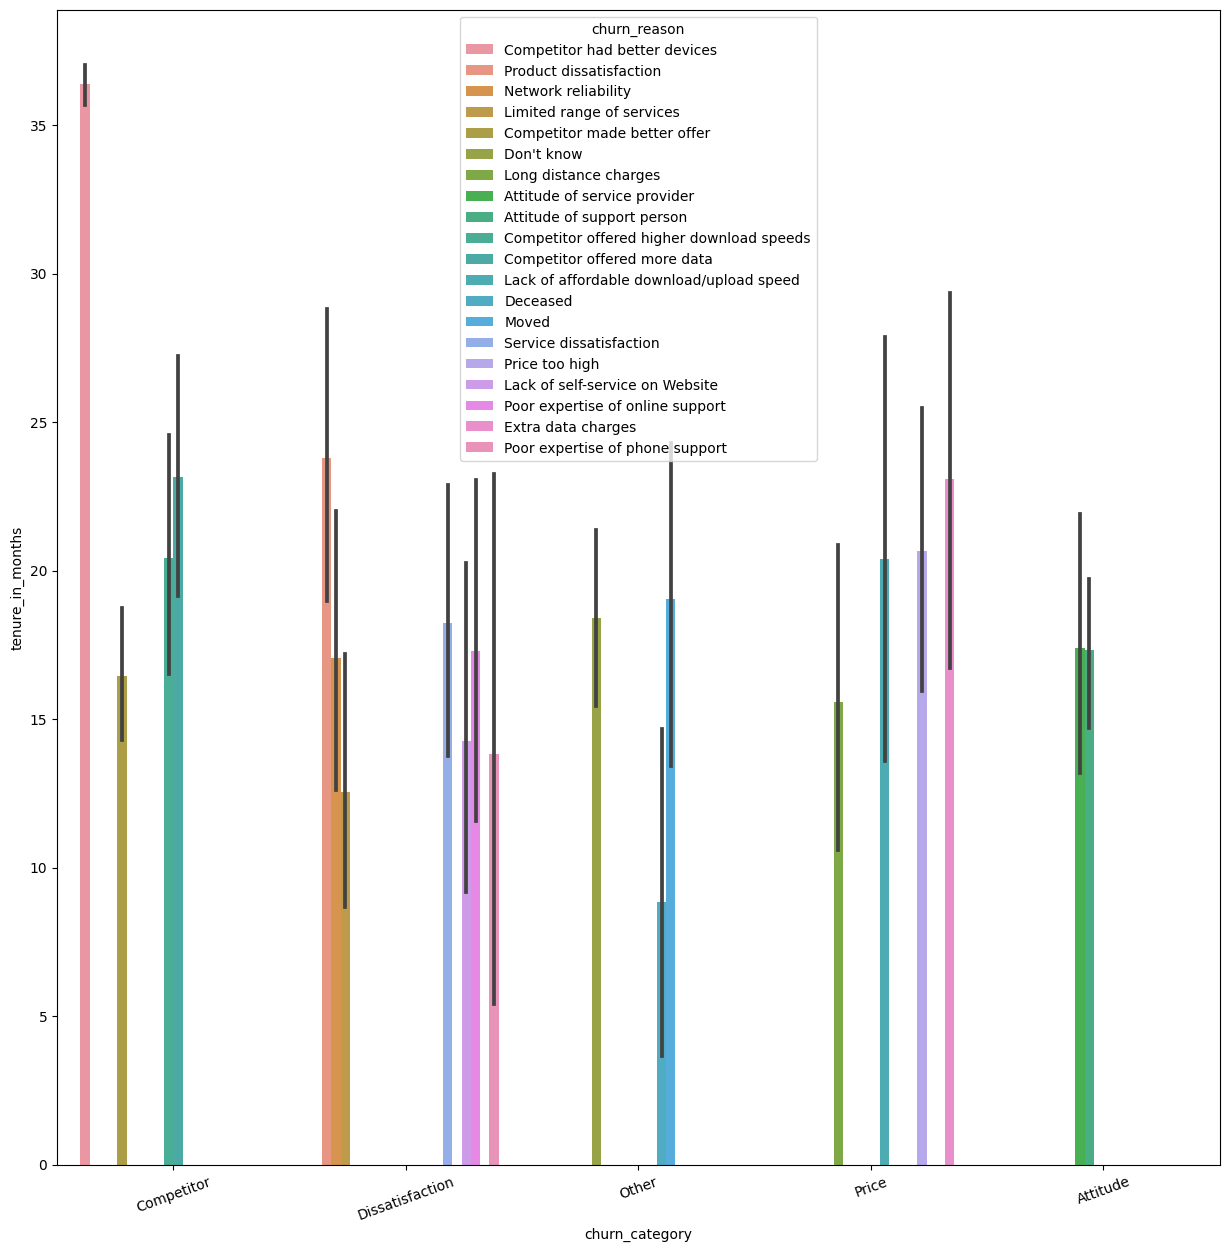

In [24]:
plt.figure(figsize=(15,15))
sns.barplot(x=df.churn_category, y=df.tenure_in_months, hue=df.churn_reason)
plt.xticks(rotation=20)
plt.show()

### 4. Feature Engineering and Selection
###### perform correlation matrix
###### Encode the target feature 
###### Split the dataset into training and testing
###### Select Features to use for training

In [25]:
# Analyse correlation between the features
corr_matrix = df.corr()
corr_matrix 

,age,number_of_dependents,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,avg_monthly_long_distance_charges,avg_monthly_gb_download,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
age,1.000000,-0.119000,-0.008183,-0.010305,0.007612,-0.025141,0.009927,-0.019000,-0.516637,0.134511,0.059684,0.024168,0.025036,0.003065,0.048265
number_of_dependents,-0.119000,1.000000,0.016493,0.029081,-0.024271,0.278003,0.108237,-0.002730,0.248410,-0.125649,0.022535,0.014023,-0.014436,0.068966,0.038038
zip_code,-0.008183,0.016493,1.000000,0.894769,-0.790564,0.001463,0.007146,0.011666,-0.002525,-0.002517,0.001978,-0.003797,-0.014550,0.005063,0.002944
latitude,-0.010305,0.029081,0.894769,1.000000,-0.885979,0.018715,0.011963,0.013701,-0.011995,-0.021613,-0.002784,-0.009901,-0.013233,0.008029,0.000082
longitude,0.007612,-0.024271,-0.790564,-0.885979,1.000000,-0.009893,-0.009672,-0.014641,0.013455,0.021052,0.003811,-0.000597,0.010461,-0.006923,0.001062
number_of_referrals,-0.025141,0.278003,0.001463,0.018715,-0.009893,1.000000,0.326975,0.001712,0.069704,0.026301,0.250378,0.024756,0.000350,0.216190,0.261853
tenure_in_months,0.009927,0.108237,0.007146,0.011963,-0.009672,0.326975,1.000000,0.012100,0.033841,0.239065,0.826074,0.059021,0.082266,0.674149,0.853146
avg_monthly_long_distance_charges,-0.019000,-0.002730,0.011666,0.013701,-0.014641,0.001712,0.012100,1.000000,0.015527,0.018455,0.016546,-0.024869,0.019822,0.525222,0.168531
avg_monthly_gb_download,-0.516637,0.248410,-0.002525,-0.011995,0.013455,0.069704,0.033841,0.015527,1.000000,-0.011866,0.029397,-0.009947,0.015291,0.021568,0.029786
monthly_charge,0.134511,-0.125649,-0.002517,-0.021613,0.021052,0.026301,0.239065,0.018455,-0.011866,1.000000,0.622810,0.023963,0.121238,0.235685,0.563249


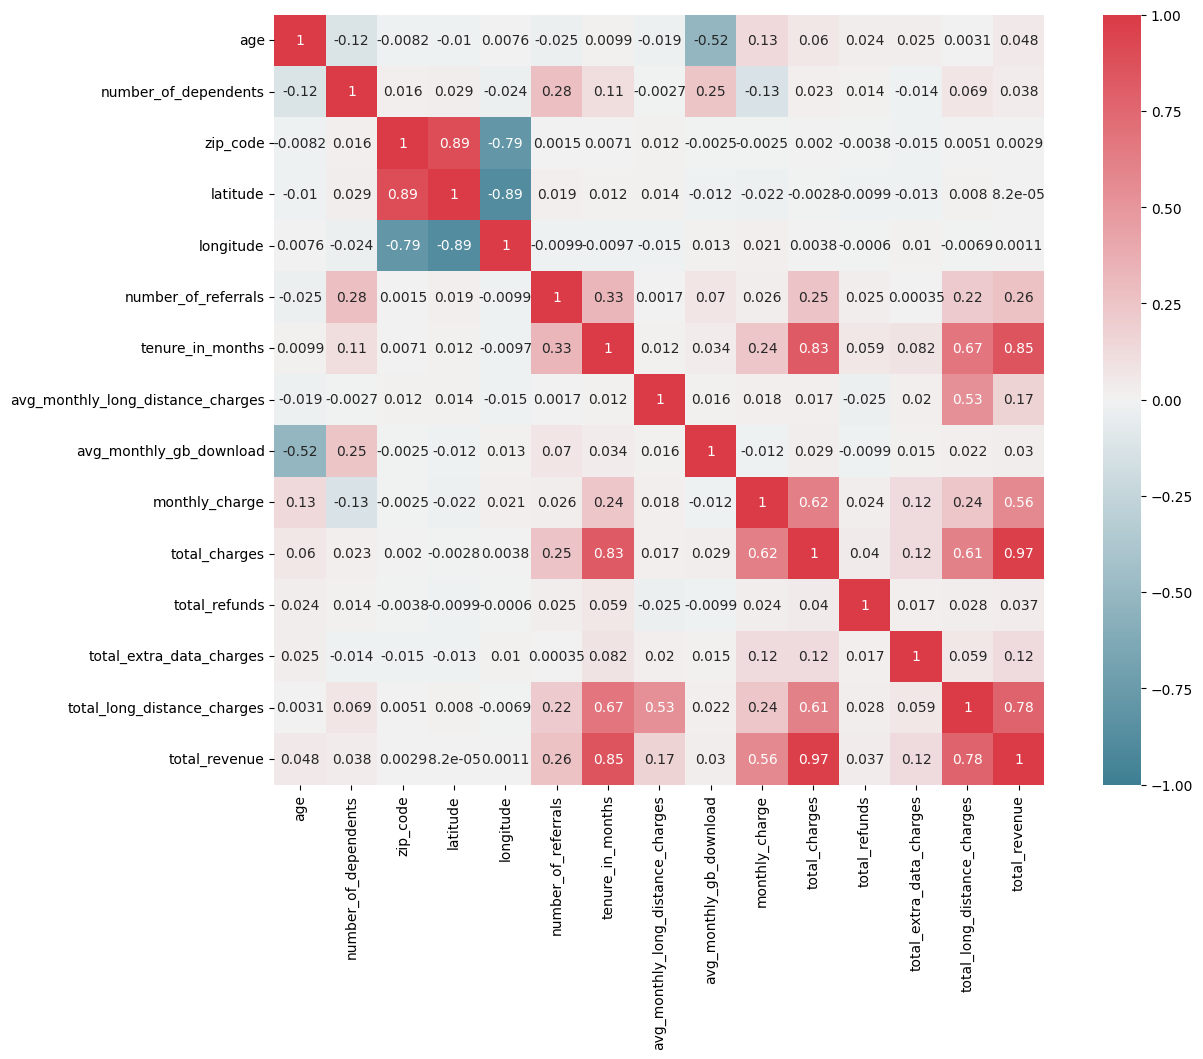

In [26]:
#let's us see the correlation of each feature
plt.figure(figsize=(15, 10))
cmap = sns.color_palette("PiYG")
sns.heatmap(corr_matrix, vmin=-1,vmax=1,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot=True)
plt.show()

###### Positive Correlation between:
###### total_revenue & tenure_in_months
###### total_revenue & total_long_distance_charges
###### total_revenue & total_charges
###### total_charges & tenure_in_months

###### Negative Correlation between:
###### longtitude & zip code
###### latitude & zip code

#### Insight: Discovering Correlation between features helps us in dimensionality reduction 
##### We can reduce total_revenue from the feature list

In [34]:
# I use Ordinal Encoding to encode the value of customer_status
# 2-> Stayed
# 1-> Joined
# 0-> Churned

encoder = OrdinalEncoder()
df['customer_status'] = encoder.fit_transform(df[['customer_status']])
df['customer_status'].value_counts(normalize=True)

2.0    0.670169
0.0    0.265370
1.0    0.064461
Name: customer_status, dtype: float64

#### Insight: We can see that the target feature is imbalanced

#### Split the dataset

In [38]:
# Split the Dataset into train and test
SEED = 42
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)
len(df_full_train), len(df_test), len(df_train)+len(df_val), len(df_train), len(df_val)

(5634, 1409, 5634, 4225, 1409)

In [39]:
# split the customer_status feature from the rest of the dataframe
y_train = df_train.customer_status.values
y_val = df_val.customer_status.values
y_test = df_test.customer_status.values

In [40]:
# delete the customer_status feature
del df_train['customer_status']
del df_val['customer_status']
del df_test['customer_status']

In [54]:
# reset index of the newly formed datasets
df_full_train = df_full_train.reset_index(drop=True)

In [53]:
df_train = df_train.reset_index(drop=True)
df_val =  df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

##### Feature Importance: Churn Rate and Risk ratio
###### identifying features that have higher effect on the target value
###### Risk Ratio


In [70]:
total_churn = df_full_train.customer_status.value_counts()[0.0]
total_churn_rate = total_churn/df_full_train.customer_status.count()

In [71]:
total_churn_rate = total_churn_rate.round(3)
total_churn_rate

0.266

In [103]:
categorical = list(df_full_train.select_dtypes(include=['O']))
categorical.remove('customer_id')

In [104]:
categorical

['gender',
 'married',
 'city',
 'offer',
 'phone_service',
 'multiple_lines',
 'internet_service',
 'internet_type',
 'online_security',
 'online_backup',
 'device_protection_plan',
 'premium_tech_support',
 'streaming_tv',
 'streaming_movies',
 'streaming_music',
 'unlimited_data',
 'contract',
 'paperless_billing',
 'payment_method',
 'churn_category',
 'churn_reason']

In [105]:

for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).customer_status.agg(['mean', 'count'])
    df_group['diff'] = total_churn_rate - df_group['mean']
    df_group['risk_ratio'] =  df_group['mean'] / total_churn_rate 
    display(df_group)
    print()
    print()

gender


,mean,count,diff,risk_ratio
gender,,,,
Female,1.400144,2774,-1.134144,5.263700
Male,1.410839,2860,-1.144839,5.303907




married


,mean,count,diff,risk_ratio
married,,,,
No,1.234765,2888,-0.968765,4.641972
Yes,1.585215,2746,-1.319215,5.959454




city


,mean,count,diff,risk_ratio
city,,,,
Acampo,1.000000,2,-0.734000,3.759398
Acton,2.000000,3,-1.734000,7.518797
Adelanto,1.500000,4,-1.234000,5.639098
Adin,0.666667,3,-0.400667,2.506266
Agoura Hills,0.800000,5,-0.534000,3.007519
...,...,...,...,...
Yreka,2.000000,3,-1.734000,7.518797
Yuba City,1.428571,7,-1.162571,5.370569
Yucaipa,1.333333,3,-1.067333,5.012531




offer


,mean,count,diff,risk_ratio
offer,,,,
None,1.384465,3077,-1.118465,5.204757
Offer A,1.873786,412,-1.607786,7.044310
Offer B,1.771852,675,-1.505852,6.661097
Offer C,1.551515,330,-1.285515,5.832764
Offer D,1.462500,480,-1.196500,5.498120
Offer E,0.722727,660,-0.456727,2.717020




phone_service


,mean,count,diff,risk_ratio
phone_service,,,,
No,1.439286,560,-1.173286,5.410849
Yes,1.401853,5074,-1.135853,5.270122




multiple_lines


,mean,count,diff,risk_ratio
multiple_lines,,,,
No,1.398779,3275,-1.132779,5.258566
Yes,1.415006,2359,-1.149006,5.319573




internet_service


,mean,count,diff,risk_ratio
internet_service,,,,
No,1.735927,1208,-1.469927,6.526042
Yes,1.315409,4426,-1.049409,4.945146




internet_type


,mean,count,diff,risk_ratio
internet_type,,,,
Cable,1.429412,680,-1.163412,5.373728
DSL,1.549694,1308,-1.283694,5.825918
Fiber Optic,1.349424,3646,-1.083424,5.073023




online_security


,mean,count,diff,risk_ratio
online_security,,,,
No,1.297566,4026,-1.031566,4.878067
Yes,1.675995,1608,-1.409995,6.300733




online_backup


,mean,count,diff,risk_ratio
online_backup,,,,
No,1.326630,3680,-1.060630,4.987332
Yes,1.554248,1954,-1.288248,5.843036




device_protection_plan


,mean,count,diff,risk_ratio
device_protection_plan,,,,
No,1.338767,3681,-1.072767,5.032957
Yes,1.531490,1953,-1.265490,5.757481




premium_tech_support


,mean,count,diff,risk_ratio
premium_tech_support,,,,
No,1.296657,4008,-1.030657,4.874649
Yes,1.674047,1626,-1.408047,6.293409




streaming_tv


,mean,count,diff,risk_ratio
streaming_tv,,,,
No,1.424661,3471,-1.158661,5.355870
Yes,1.374942,2163,-1.108942,5.168956




streaming_movies


,mean,count,diff,risk_ratio
streaming_movies,,,,
No,1.420332,3433,-1.154332,5.339594
Yes,1.382553,2201,-1.116553,5.197569




streaming_music


,mean,count,diff,risk_ratio
streaming_music,,,,
No,1.412864,3638,-1.146864,5.311520
Yes,1.392285,1996,-1.126285,5.234153




unlimited_data


,mean,count,diff,risk_ratio
unlimited_data,,,,
No,1.266892,592,-1.000892,4.762751
Yes,1.421856,5042,-1.155856,5.345325




contract


,mean,count,diff,risk_ratio
contract,,,,
Month-to-Month,0.958464,2865,-0.692464,3.603249
One Year,1.778400,1250,-1.512400,6.685714
Two Year,1.942067,1519,-1.676067,7.301004




paperless_billing


,mean,count,diff,risk_ratio
paperless_billing,,,,
No,1.575111,2250,-1.309111,5.921470
Yes,1.292849,3384,-1.026849,4.860333




payment_method


,mean,count,diff,risk_ratio
payment_method,,,,
Bank Withdrawal,1.265181,3096,-0.999181,4.756319
Credit Card,1.632379,2236,-1.366379,6.136764
Mailed Check,1.165563,302,-0.899563,4.381815




churn_category


,mean,count,diff,risk_ratio
churn_category,,,,
Attitude,0.000000,261,0.266000,0.000000
Competitor,1.645677,4812,-1.379677,6.186757
Dissatisfaction,0.000000,261,0.266000,0.000000
Other,0.000000,140,0.266000,0.000000
Price,0.000000,160,0.266000,0.000000




churn_reason


,mean,count,diff,risk_ratio
churn_reason,,,,
Attitude of service provider,0.000000,80,0.266000,0.00000
Attitude of support person,0.000000,181,0.266000,0.00000
Competitor had better devices,1.808404,4379,-1.542404,6.79851
Competitor made better offer,0.000000,254,0.266000,0.00000
Competitor offered higher download speeds,0.000000,82,0.266000,0.00000
Competitor offered more data,0.000000,97,0.266000,0.00000
Deceased,0.000000,4,0.266000,0.00000
Don't know,0.000000,102,0.266000,0.00000
Extra data charges,0.000000,31,0.266000,0.00000


##### Insight:
###### Risk_ratio > 1,  customer is more likely to churn
###### All the categorical features have atleast one group with risk_ratio > 1

#### Feature Importance: Mutual information

In [106]:
def mutual_info_churn_rate(series):
    return mutual_info_score(series, df_full_train.customer_status)

In [107]:
mutual_info = df_full_train[categorical].apply(mutual_info_churn_rate)
mutual_info.sort_values(ascending=False)

churn_reason              0.413145
churn_category            0.232780
city                      0.219540
contract                  0.166352
offer                     0.090632
internet_service          0.034229
married                   0.030296
payment_method            0.029390
online_security           0.025025
premium_tech_support      0.024985
paperless_billing         0.018841
multiple_lines            0.018140
device_protection_plan    0.016865
online_backup             0.014549
streaming_movies          0.013457
streaming_tv              0.012894
streaming_music           0.009846
internet_type             0.005210
unlimited_data            0.001505
gender                    0.000238
phone_service             0.000156
dtype: float64

##### Insight:
###### Relevant features:
###### Features with Mutual Info_score close to 1 are very relevant
###### Features with Mutual Info_score close to 0 are not that relevant
###### [churn_reason, churn_category,city, contract,offer, internet_service]

##### Check the correlation with the target value
###### correlation of the numeric values with the target feature
###### Positive Correlation => the higher the feature value the higher the churn rate
###### Negative Correlation => the higher the feature value the lower the churn rate 

In [89]:
df_full_train[numeric].corrwith(df_full_train.customer_status)

age                                 -0.097900
number_of_dependents                 0.224949
zip_code                             0.020187
latitude                             0.041723
longitude                           -0.021510
number_of_referrals                  0.314791
tenure_in_months                     0.449537
avg_monthly_long_distance_charges   -0.000653
avg_monthly_gb_download              0.077674
monthly_charge                      -0.137892
total_charges                        0.274888
total_refunds                        0.056299
total_extra_data_charges            -0.002976
total_long_distance_charges          0.289908
total_revenue                        0.302622
dtype: float64

##### Insight:
##### Features with low correlation are irrelevant to the model
##### Relevant Features:
###### [ number_of_dependents,number_of_referrals,tenure_in_months',monthly_charge,total_charges,total_refunds,total_long_distance_charges,total_revenue]

In [109]:
# final features selected
numeric =  [ 
    'number_of_dependents',
            'number_of_referrals',
            'tenure_in_months',
            'monthly_charge',
            'total_charges',
            'total_refunds',
            'total_long_distance_charges',
            'total_revenue'
            ]

categorical = [
    'churn_reason',
     ' churn_category',
     'city',
      'contract',
      'offer', 
      'internet_service'
]

### 5. Model Training and Selection

###### One-Hot Encoding => To normalize the categorical and numeric datasets into dictionaries
###### 1. LogisticRegression()-> for multiclasslabel classification
###### 2. RandomForestClassifier() for multiclasslabel classification
###### 3.  xgb.XGBClassifier() for multiclasslabel classification

In [ ]:
def train(data, y,sparse, model, C=1.0):
    dicts = data[categorical + numeric].to_dict(orient='records')

    dv = DictVectorizer(sparse=sparse)
    X_train = dv.fit_transform(dicts)

    m = model.fit(X_train, y)

    return dv, m

def predict(data, dv, model):
    dicts = data[categorical + numeric].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

### 1. LogisticRegression

In [ ]:
lr = LogisticRegression(multi_class=)